In [1]:
import sys
sys.path.append("..")

In [ ]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('timestamp_proc', Pipeline([
#             ('impute', DatetimeImputer(strategy='median')),
#             ('encode', TimestampTransformer())
#         ]), ['timestamp']),
        
#         ('num_proc', StandardScaler(), ['feature_1'])
#     ]
# )


In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.custom_sklearn_transformers import DateTimeImputer, TimeStampTransformer

In [3]:
spark = (
    SparkSession.builder
    .appName('iot_data_ingestion')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
25/06/09 12:34:56 WARN Utils: Your hostname, HP-Pavilion-15-ec2121nr resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/06/09 12:34:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ubuntu/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ed50df30-7cf8-4a38-ab9c-c3de65dd2232;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 185ms :: artifacts dl 7ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.0 from central in [default]
	io.delta#delta-storage;3.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0 

In [4]:
sensor_training_data = spark.read.format('delta').load('../data/silver/spark_turbine_training_dataset')
sensor_bronze = spark.read.format('delta').load('../data/bronze/bronze_incoming_data')

In [5]:
def plot_sensor_data(sensor_report):
    turbine_id = sensor_training_data.where(f"abnormal_sensor = '{sensor_report}'").limit(1).collect()[0]['turbine_id']
    df = sensor_bronze.where(f"turbine_id = '{turbine_id}'").orderBy('timestamp').limit(500).toPandas()
    df.plot(x='timestamp', y='sensor_B', kind='line', figsize=(15, 5), title=f'Sensor report for {sensor_report}')
    plt.show()

25/06/09 12:35:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


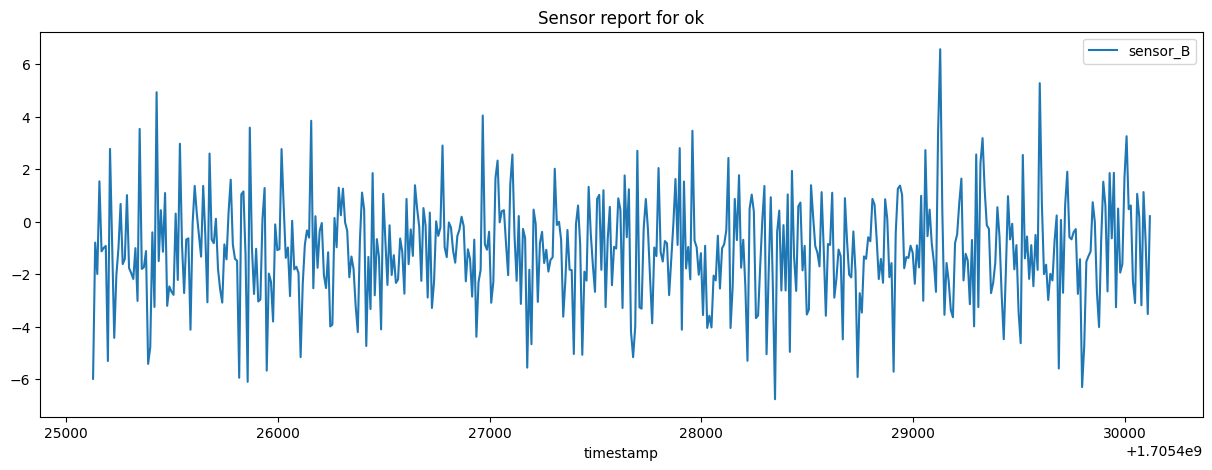

In [6]:
plot_sensor_data('ok')

Clearly some anomaly in the data

In [7]:
sensor_training_data = sensor_training_data.withColumn('damaged', F.col('abnormal_sensor') != 'ok')
sensor_training_data.show(5)

+--------------------+-------------------+-------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+------------------+--------------------+-------+--------+--------------+----------+--------+---------------+---------------+----------+--------------------+----------+-------+
|          turbine_id|   hourly_timestamp|         avg_energy|      std_sensor_E|percentiles_sensor_E|      std_sensor_C|percentiles_sensor_C|      std_sensor_B|percentiles_sensor_B|      std_sensor_A|percentiles_sensor_A|      std_sensor_F|percentiles_sensor_F|      std_sensor_D|percentiles_sensor_D|country|     lat|      location|      long|   model|          state|abnormal_sensor|  end_time|  maintenance_report|start_time|damaged|
+--------------------+-------------------+-------------------+------------------+--------------------+------------------+---

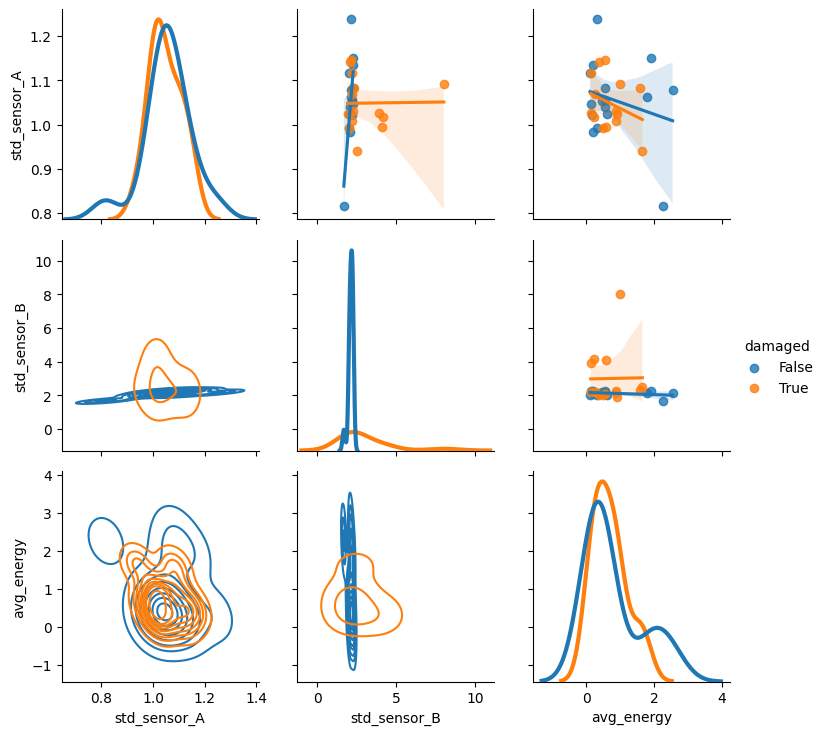

In [8]:
g = sns.PairGrid(sensor_training_data.sample(0.01).toPandas()[['std_sensor_A', 'std_sensor_B', 'damaged', 'avg_energy']], diag_sharey=False, hue='damaged')
g.map_lower(sns.kdeplot).map_diag(sns.kdeplot, lw=3).map_upper(sns.regplot).add_legend()

In [9]:
# convert spark dataframe to pandas
training_data = sensor_training_data.toPandas()

columns = [
    'hourly_timestamp',
    'avg_energy',
    'std_sensor_A',
    'std_sensor_B',
    'std_sensor_C',
    'std_sensor_D',
    'std_sensor_E',
    'std_sensor_F',
    'location',
    'model',
    'state',
    'abnormal_sensor'
]

training_data = training_data.filter(columns)
training_data.dropna(inplace=True)
training_data.head()

,hourly_timestamp,avg_energy,std_sensor_A,std_sensor_B,std_sensor_C,std_sensor_D,std_sensor_E,std_sensor_F,location,model,state,abnormal_sensor
0,2024-01-16 10:00:00,0.128397,1.065609,1.926332,3.333056,2.230040,2.354626,1.891305,Crystal Lake,EpicWind,America/Chicago,ok
1,2024-01-16 10:00:00,0.521966,1.177228,2.389566,2.995943,2.243178,2.050527,2.070701,Gilbert,EpicWind,America/Phoenix,ok
2,2024-01-16 10:00:00,0.203298,1.005230,2.159258,3.091891,2.200497,2.605007,1.980276,Evergreen Park,EpicWind,America/Chicago,ok
3,2024-01-16 10:00:00,0.320839,1.052481,2.142756,3.321686,2.238120,2.323231,1.882345,Kearns,EpicWind,America/Denver,ok
4,2024-01-16 10:00:00,0.116663,1.058341,6.244760,3.198752,2.331885,2.784077,2.071526,Bourbonnais,EpicWind,America/Chicago,sensor_B


### Data Preprocessing

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
# Pipeline
numerical_pipeline = ColumnTransformer(
    transformers=[
        
        # ('timestamp_pipeline',
        #  Pipeline([
        #     ('impute_datetime', DateTimeImputer(strategy='median')),
        #     ('encode_timestamp', TimeStampTransformer(granularity='month'))
        #  ]),
        #  ['hourly_timestamp']),
        
        ('numerical_pipeline', 
         Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), 
         [col for col in training_data.columns if col.startswith('std_') or col == 'avg_energy']),
        
        ('categorical_pipeline',
         Pipeline([
             ('imputers', SimpleImputer(strategy='most_frequent')),
             ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
         ]),
         ['location', 'model', 'state', 'abnormal_sensor'] + [col for col in training_data.columns if col.endswith('_ts')])
    ],
    remainder='drop'
)

In [ ]:
r = numerical_pipeline.fit_transform(training_data.copy())

In [20]:
pd.to_datetime(training_data['hourly_timestamp']).mode()[0]

Timestamp('2024-01-16 10:00:00')

In [15]:
training_data['hourly_timestamp'].shape

(3584,)

In [11]:
dt = DateTimeImputer(strategy='median')
dt.fit_transform(training_data[['hourly_timestamp']])

AttributeError: 'NoneType' object has no attribute 'transform'

In [ ]:
assert (training_data[['hourly_timestamp']].shape[1] == 1)

In [ ]:
isinstance(training_data[['hourly_timestamp']], pd.DataFrame)

In [ ]:
si = TimeStampTransformer(granularity='month')
si.fit_transform(training_data[['hourly_timestamp']])